In [11]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from uitils import *
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, recall_score, f1_score, confusion_matrix

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import lightgbm as lgb
print('GPU support:', lgb.LGBMClassifier(device='gpu').get_params()['device'])



Num GPUs Available:  1
GPU support: gpu


# Data Loading

In [4]:
import numpy as np
from keras.datasets import mnist
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Random samples selector
def extract_samples(x, y, num_samples):
    indices = np.random.choice(x.shape[0], num_samples, replace=False)
    return x[indices], y[indices]

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, y_train = extract_samples(x_train, y_train, 500)
# x_test, y_test = extract_samples(x_test, y_test, 100)
print("Reduced training set shape:", x_train.shape)
print("Reduced testing set shape:", x_test.shape)

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the images for LightGBM
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Convert labels to 0 (even) and 1 (odd)
y_train = y_train % 2
y_test = y_test % 2

# Initialize 's' to zeros, meaning initially all are unlabeled
s = np.zeros_like(y_train)

# Select a random 1000 samples where y_train == 1 to be labeled
positive_indices = np.where(y_train == 1)[0]
chosen_indices = np.random.choice(positive_indices, size=1000)

# Mark these as labeled in 's'
s[chosen_indices] = 1

# Mark the rest of the positive_indices except the chosen 1000 as potential targets for unlabeled marking
rest_of_positives = np.setdiff1d(positive_indices, chosen_indices)

# From the rest, select 3% and mark their labels as 0 in y_train
number_to_mark_unlabeled = int(len(rest_of_positives) * 0.03)
unlabeled_indices = np.random.choice(rest_of_positives, size=number_to_mark_unlabeled)
y_train[unlabeled_indices] = 0

# Remove the rest of the positive rows that are not in the chosen 1000 and not marked as unlabeled
indices_to_drop = np.setdiff1d(rest_of_positives, np.concatenate([chosen_indices, unlabeled_indices]))
x_train = np.delete(x_train, indices_to_drop, axis=0)
y_train = np.delete(y_train, indices_to_drop)
s = np.delete(s, indices_to_drop)

print("Training labels distribution:", np.bincount(y_train))
print("Training original labels distribution:", np.bincount(s))


Reduced training set shape: (60000, 28, 28)
Reduced testing set shape: (10000, 28, 28)
Training labels distribution: [30367   993]
Training original labels distribution: [30367   993]


# Pre-training

In [7]:
# Import LightGBM
import lightgbm as lgb

#  datasets creation for LightGBM
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)

##parameters for LightGBM
params = {
    'boosting_type': 'gbdt',        # Gradient boosting decision tree
    'objective': 'binary',          # Binary classification
    'metric': 'binary_logloss',     # Evaluation metric
    'num_leaves': 31,               # Number of leaves in full tree
    'learning_rate': 0.01,          # Learning rate
    'feature_fraction': 0.9,        # Fraction of features to be used at each iteration
    'bagging_fraction': 0.8,        # Fraction of data to be used for each iteration
    'bagging_freq': 5,              # Frequency for bagging
    'device': 'gpu',                # Use GPU for training
    'verbose': 1                    # Verbose output
}

# boosting rounds
num_boost_round = 15

#  model
model_lgb = lgb.train(params, train_data, num_boost_round=num_boost_round, valid_sets=[test_data])

model_lgb.save_model('lgb_model_mnist.weights.h5')

# predicted probabilities
y_pred_prob = model_lgb.predict(x_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047758 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031665 -> initscore=-3.420381
[LightGBM] [Info] Start training from score -3.420381
Accuracy: 0.4926


Classifer predicted labels distribution: [   34 31326]


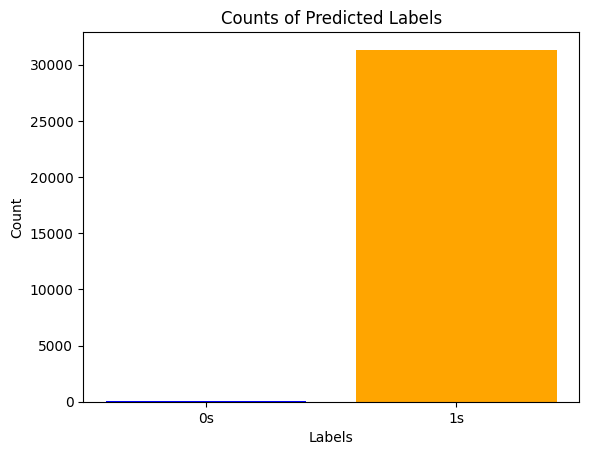

In [8]:
y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
threshold = min(y_pred[y_train == 1])
lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

bin_ploter(predicted_labels=lgb_predicted_labels)

### Probablistic outcome of classifer to pre-train policy network
 

In [9]:
# Policy-Network Model

class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        model = Sequential([
            Dense(64, input_shape=(input_dimension,)),  # Adjust `input_dimension` to match your feature count
            Activation('relu'),
            Dense(128),
            Activation('relu'),
            Dense(64),
            Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(16),
            Activation('relu'),
            Dense(1),  # Output layer for binary classification
            Activation('sigmoid')
        ])
        return model
    
    def get_model(self):
        return self.model
    
input_dimension = x_train.shape[1]
policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# fit the model with one-hot encoded labels
# history_2 = pn_model.fit(x_train.to_numpy(), lgb_predicted_labels, epochs=60, batch_size=5, validation_split=0.2)
history_2 = pn_model.fit(x_train, lgb_predicted_labels, epochs=15, batch_size=128, validation_split=0.2)
pn_model.save_weights('pn_mlp_model_.weights.h5')
# pn_model.load_weights('pn_mlp_model_.weights.h5')

Epoch 1/15
196/196 [==============================] - 10s 37ms/step - loss: 0.0170 - accuracy: 0.9989 - val_loss: 0.0122 - val_accuracy: 0.9984
Epoch 2/15
196/196 [==============================] - 7s 36ms/step - loss: 0.0091 - accuracy: 0.9990 - val_loss: 0.0174 - val_accuracy: 0.9984
Epoch 3/15
196/196 [==============================] - 7s 36ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0150 - val_accuracy: 0.9984
Epoch 4/15
196/196 [==============================] - 7s 36ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0172 - val_accuracy: 0.9984
Epoch 5/15
196/196 [==============================] - 7s 36ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0146 - val_accuracy: 0.9984
Epoch 6/15
196/196 [==============================] - 7s 34ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0137 - val_accuracy: 0.9984
Epoch 7/15
196/196 [==============================] - 7s 35ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0172 - val_accuracy: 0.998

980/980 [==============================] - 9s 9ms/step
Classifer predicted labels distribution: [  143 31217]


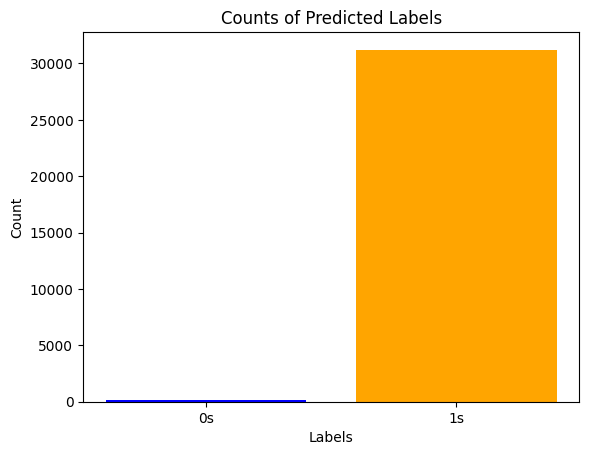

In [10]:
probabilities = pn_model.predict(x_train)
threshold = min(probabilities[y_train == 1])

# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))
bin_ploter(predicted_labels=np_predicted_labels)

## Interactive learning

In [12]:
class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    
    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states) 
        
        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()



    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma

            G[t] = G_sum

        # updating policy
        with tf.GradientTape() as tape:
            loss = 0

            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # clearing memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [13]:
# cloning policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[],
    'recall':[],
    'f1':[]
}

agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# Example parameters
n_epochs = 300
# n_epochs = 10 #for testing
batch_size = 128 # You can adjust the batch size as needed

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indices of positive examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify U0 - samples with predictions >= threshmin
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold
    # Positive examples above threshold or negative examples below threshold get positive rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  # Reward is the probability itself if conditions are met
        else:
            reward = prob -1  # Otherwise, reward is the complement of the probability
        rewards.append(reward)
    return rewards

In [13]:
# num_initial_round = 5
# model_lgb = lgb.train(params, train_data, num_boost_round=num_initial_round, valid_sets=[test_data])
# model_lgb.save_model('lgb_model.we7ights.h5')


# y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
# threshold = min(y_pred[y_train == 1])
# lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
# print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

In [15]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, model_lgb=model_lgb):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(len(y_train))
    # dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # lgb_probabilities=None
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)
            train_data = lgb.Dataset(x_batch, label=actions)
            valid_data = lgb.Dataset(x_batch, label=actions)
            model_lgb = lgb.train(params, train_data, num_boost_round=1, init_model=model_lgb, keep_training_booster=True)
    

            # Fit the model on the current batch and update history

            lgb_probabilities = model_lgb.predict(x_batch, num_iteration=model_lgb.best_iteration)
            threshold = calculate_threshold(lgb_probabilities, y_batch)
            rewards = calculate_rewards(lgb_probabilities, y_batch, threshold)

            # Store transitions and learn from them
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break

        y_pred_prob = model_lgb.predict(x_test)
        threshold = calculate_threshold(y_pred_prob, y_test)
        print(f"threshold: {threshold}")
        y_pred = np.where(y_pred_prob >= threshold, 1, 0)

        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("AUC-ROC:", roc_auc)
        history['ROC_AUC'].append(roc_auc)

        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)
        history['accuracy'].append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_pred_prob)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        print("PR_AUC:", pr_auc)

        # conf_matrix = confusion_matrix(y_test, y_pred)
        # print("Confusion Matrix:")
        # print(conf_matrix)
        # Test the confustion matrix and test the inputs

        # recall = recall_score(y_test, y_pred)
        # print("Recall:", recall)
        # history['recall'].append(recall)

        # # Calculate F1 score
        # f1 = f1_score(y_test, y_pred)
        # print("F1 Score:", f1)
        # history['f1'].append(f1)


        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=y_train, model_lgb=model_lgb)

Epoch 1/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 7992, number of negative: 23368
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.045700 secs. 1 sparse feature groups
threshold: 0.05360535990794844
AUC-ROC: 0.9380678543828241
Accuracy: 0.8213
PR_AUC: 0.9543319390093735
Updating target policy...
Epoch 2/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056120 secs. 1 sparse feature groups
threshold: 0.05472806676199911
AUC-ROC: 0.9393697195433687
Accuracy: 0.8217
PR_AUC: 0.9553637010357656
Epoch 3/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.052240 secs. 1 sparse feature groups
threshold: 0.055885192298258536
AUC-ROC: 0.9408402016377666
Accuracy: 0.8249
PR_AUC: 0.9565683704676351
Epoch 4/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.054272 secs. 1 sparse feature groups
threshold: 0.05697921348136528
AUC-ROC: 0.9416212127104323
Accuracy: 0.8238
PR_AUC: 0.9572577825959652
Updating target policy...
Epoch 5/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.047803 secs. 1 sparse feature groups
threshold: 0.057995566421240125
AUC-ROC: 0.9422020599392092
Accuracy: 0.824
PR_AUC: 0.9579352061997826
Epoch 6/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.050227 secs. 1 sparse feature groups
threshold: 0.05916467649353003
AUC-ROC: 0.9436373743304733
Accuracy: 0.8269
PR_AUC: 0.9593403178591755
Epoch 7/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.051363 secs. 1 sparse feature groups
threshold: 0.06037120295324775
AUC-ROC: 0.9451560069717672
Accuracy: 0.8286
PR_AUC: 0.9605058968705633
Updating target policy...
Epoch 8/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.048384 secs. 1 sparse feature groups
threshold: 0.061568666685028105
AUC-ROC: 0.946420884030438
Accuracy: 0.8301
PR_AUC: 0.9614921081554617
Epoch 9/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.051773 secs. 1 sparse feature groups
threshold: 0.06277593446722977
AUC-ROC: 0.9468353148073554
Accuracy: 0.8327
PR_AUC: 0.9619972621876234
Epoch 10/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.054067 secs. 1 sparse feature groups
threshold: 0.06393710230659928
AUC-ROC: 0.9471034935492271
Accuracy: 0.8336
PR_AUC: 0.962282135684555
Updating target policy...
Epoch 11/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.049598 secs. 1 sparse feature groups
threshold: 0.06507908526246219
AUC-ROC: 0.9476935027848501
Accuracy: 0.8363
PR_AUC: 0.9627970948042041
Epoch 12/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 993, number of negative: 30367
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99520
[LightGBM] [Info] Number of data points in the train set: 31360, number of used features: 584
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057893 secs. 1 sparse feature groups


In [ ]:
import pickle
with open('history_XGB.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_XGB.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

{'epoch_loss': [], 'epoch_accuracy': [], 'batch_loss': [], 'batch_accuracy': [], 'predictions': [], 'rewards': [], 'thresholds': [], 'ROC_AUC': [0.9709253314846085, 0.9709262116774058, 0.9709672206600135, 0.9709956668908757, 0.9710671225425216, 0.9712279977806337, 0.9713750299865682, 0.9714116780139522, 0.9714590483899594, 0.9715008575478373, 0.9715859161790799, 0.9715948381333448, 0.9717408701201911, 0.971727387166885, 0.971882861221922, 0.971978802236842, 0.9720523783529544, 0.9720166905358951, 0.9722387391734286, 0.9722567031082487, 0.9725895560163498, 0.9726204827905505, 0.9728475525279057, 0.9732176735992253, 0.9731871469126597, 0.9732246351240774, 0.9731860266672812, 0.9735208200004128, 0.9738787584032407, 0.974095745932189, 0.9742155721789302, 0.9742467390057119, 0.9743933711240109, 0.9745703298850579, 0.9745908943895071, 0.9746315232888612, 0.9746550884505742, 0.9748740564133167, 0.9748689352915862, 0.9749404709607592, 0.9749190062591311, 0.9749458521394526, 0.9751578985861064,

In [16]:
# import matplotlib.pyplot as plt

# # Plotting epoch losses and accuracies
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history['batch_loss'], label='Loss')
# plt.title('Epoch Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['batch_accuracy'], label='Accuracy')
# plt.title('Epoch Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# # You can add more plots for batch-level data, rewards, thresholds, etc.


# Visual

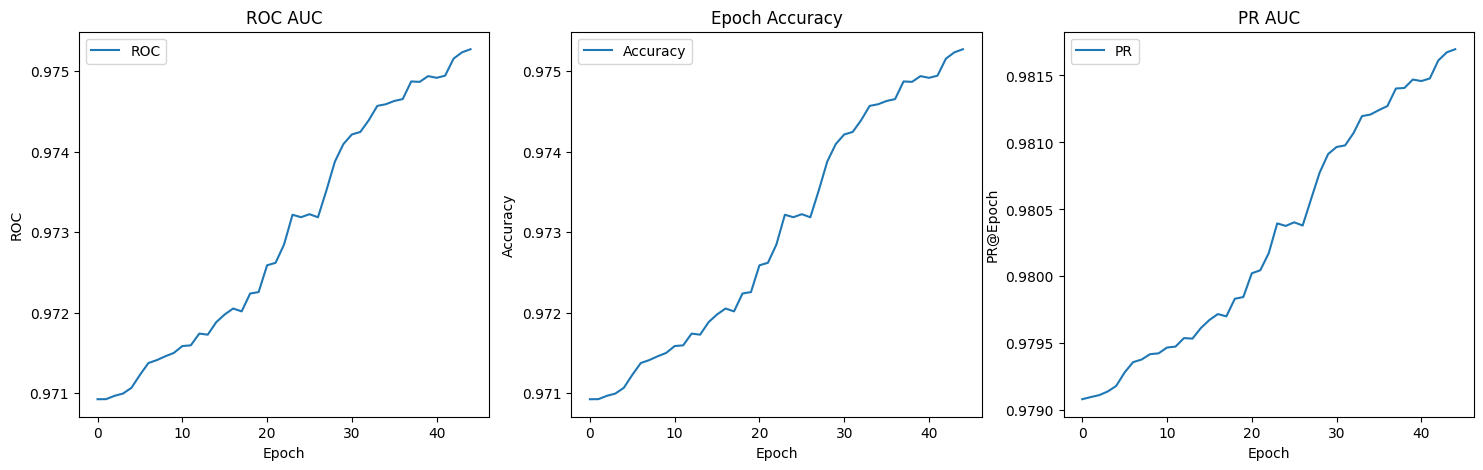

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='ROC')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='PR')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()    

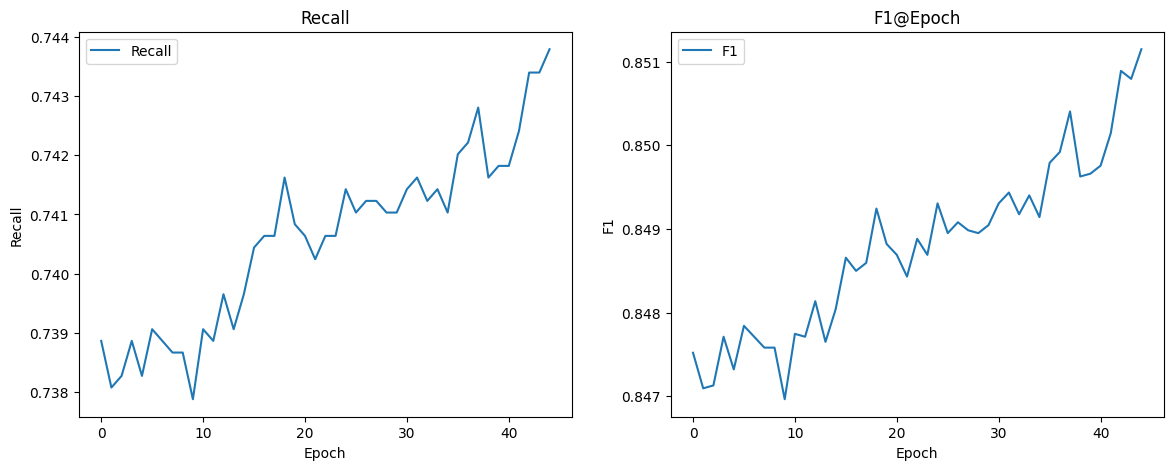

In [18]:
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history['recall'], label='Recall')
# plt.title('Recall')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['f1'], label='F1')
# plt.title('F1@Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('F1')
# plt.legend()

# # plt.subplot(1, 3, 3)
# # plt.plot(history['PR_AUC'], label='Accuracy')
# # plt.title('PR AUC')
# # plt.xlabel('Epoch')
# # plt.ylabel('PR@Epoch')
# # plt.legend()